In [23]:
# from __future__ import print_function
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dom_colors import dom_colors, remove_color
from skimage import color, io
from skimage import measure
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
import matplotlib.patches as mpatches

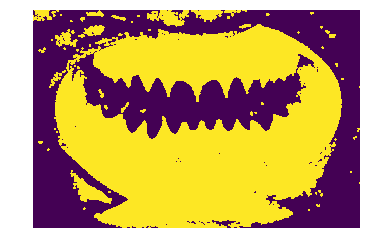

In [24]:
orig = io.imread("photos/oral1.png")
oral = color.rgb2lab(orig)
oral = (oral + [0, 128, 128]) / [100, 255, 255]
oral = oral[:,:,1]

# no need for dominant color removal: lab colorspace + thresholding works fine due to blue/red contrast
# dc = dom_colors(oral, num_colors=2, use_BGR=False, num_clusters=3)
# oral_rem = remove_color(oral, dc[1], tolerance=0.8)

thresh = np.mean(oral)
oral[oral>thresh]=255
oral[oral<thresh]=0
selem = disk(5)
oral = dilation(oral, selem)

plt.axis("off")
plt.imshow(oral)
plt.show()

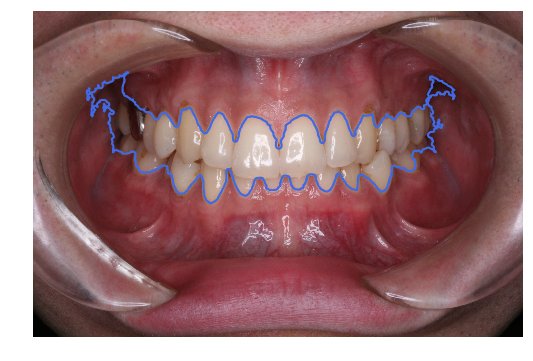

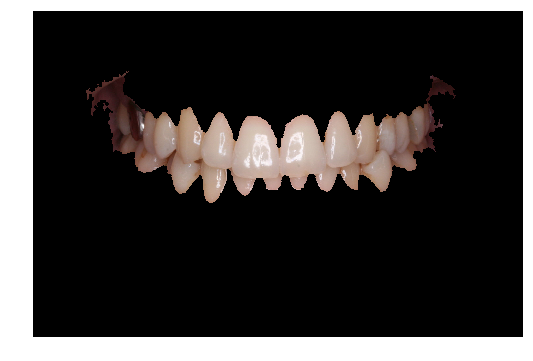

In [25]:
contours = measure.find_contours(oral, 0.7)

fig1, ax1 = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))

oral_area = oral.shape[0]*oral.shape[1]

# -- (labeling vs contours: labels first)
label_image = measure.label(oral)
image_label_overlay = color.label2rgb(label_image, image=oral)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 0.05*oral_area:
        mouth_mask = region.filled_image
        min_row, min_col, max_row, max_col = region.bbox
        mouth_view = orig.copy()
        mouth_view = mouth_view[min_row:max_row, min_col:max_col]
        mouth_view[mouth_mask!=True] = (0,0,0)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ## ax.add_patch(rect)

# -- (now contours...seems to work better)
# opencv has better contour helper functions so convert from skimage
converted = []
mask = np.ones(orig.shape[:2], dtype="uint8")*255
# mask = np.zeros_like(toral)
for n, contour in enumerate(contours):
    # append contour with empty dimension for cv2 compatibility
    c_conv = np.expand_dims(np.fliplr(contour), axis=1).astype(np.int32)
    # ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
    if 0.4*oral_area > cv2.contourArea(c_conv) > 0.05*oral_area:
        cv2.drawContours(mask, [c_conv], -1, 0, -1)
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, color="royalblue")
        converted.append(c_conv)
    pass

image = cv2.bitwise_and(orig, orig, mask=np.invert(mask))
ax1.axis("off")
ax2.axis("off")
ax1.imshow(orig)
ax2.imshow(image)
plt.show()

# now on to individual tooth segmentation attempts if you dare;
# or quality metrics to display if photo seems correctly taken

In [ ]:
# now on to individual tooth segmentation attempts if you dare;
# or quality metrics to display if photo seems correctly take
